# Visualising data from BGc-Argo floats

In [1]:
import xarray as xr
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib3
from datetime import datetime, timedelta
from scipy import interpolate


In [2]:
def absoluteFilePaths(directory):
    filelist = []
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            filelist.append(os.path.abspath(os.path.join(dirpath, f)))
    return filelist

## Open NCDF database

Selecting wmo

In [3]:
wmo = '4903532'

Open NCDF database downloaded from 'download_data.ipynb'.

In [4]:
root = 'C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/'
data_directory = 'C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data'
wmo_directory = data_directory + '/argo_nc/' + wmo
wmo_file_list = absoluteFilePaths(wmo_directory)

In [5]:
data = xr.open_dataset(wmo_file_list[0])
data = data.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
display(data)

<xarray.Dataset> Size: 5MB
Dimensions:                          (PROF_NUM: 33, N_PARAM: 9, N_CALIB: 1,
                                      N_LEVELS: 519)
Coordinates:
  * PROF_NUM                         (PROF_NUM) float64 264B 1.0 2.0 ... 34.0
Dimensions without coordinates: N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/92)
    DATA_TYPE                        object 8B ...
    FORMAT_VERSION                   object 8B ...
    HANDBOOK_VERSION                 object 8B ...
    REFERENCE_DATE_TIME              object 8B ...
    DATE_CREATION                    object 8B ...
    DATE_UPDATE                      object 8B ...
    ...                               ...
    NITRATE                          (PROF_NUM, N_LEVELS) float32 69kB ...
    NITRATE_QC                       (PROF_NUM, N_LEVELS) object 137kB ...
    NITRATE_dPRES                    (PROF_NUM, N_LEVELS) float32 69kB ...
    NITRATE_ADJUSTED                 (PROF_NUM, N_LEVELS) float32 69kB ...
    NITRATE_ADJUSTED_QC              (PROF_NUM, N_LEVELS) object 137kB ...
    NITRATE_ADJUSTED_ERROR           (PROF_NUM, N_LEVELS) float32 69kB ...
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2024-03-30T20:03:39Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

In [10]:
lon = data[['LONGITUDE', 'LATITUDE', 'POSITION_QC']].to_dataframe()

          LONGITUDE  LATITUDE POSITION_QC
PROF_NUM                                 
1.0        -19.8661   59.9345        b'1'
2.0        -19.6498   60.4443        b'1'
3.0        -20.1017   60.4921        b'1'
4.0        -19.8409   60.7486        b'1'
5.0        -19.2193   61.0747        b'1'
6.0        -18.2689   61.2089        b'1'
7.0        -17.9474   61.6741        b'1'
8.0        -19.2198   62.2494        b'1'
9.0        -21.7143   61.5619        b'1'
10.0       -22.7280   61.8537        b'1'
11.0       -23.6811   61.4604        b'1'
12.0       -24.0800   60.9040        b'1'
13.0       -24.2454   60.9804        b'1'
14.0       -24.7846   61.2452        b'1'
15.0       -24.3320   61.3139        b'1'
16.0       -24.7769   61.2140        b'1'
17.0       -24.8111   61.1369        b'1'
18.0       -25.0290   61.2426        b'1'
19.0       -25.0119   60.8784        b'1'
20.0       -26.2974   60.5073        b'1'
21.0       -27.0920   60.2428        b'1'
22.0       -27.0153   60.3299     

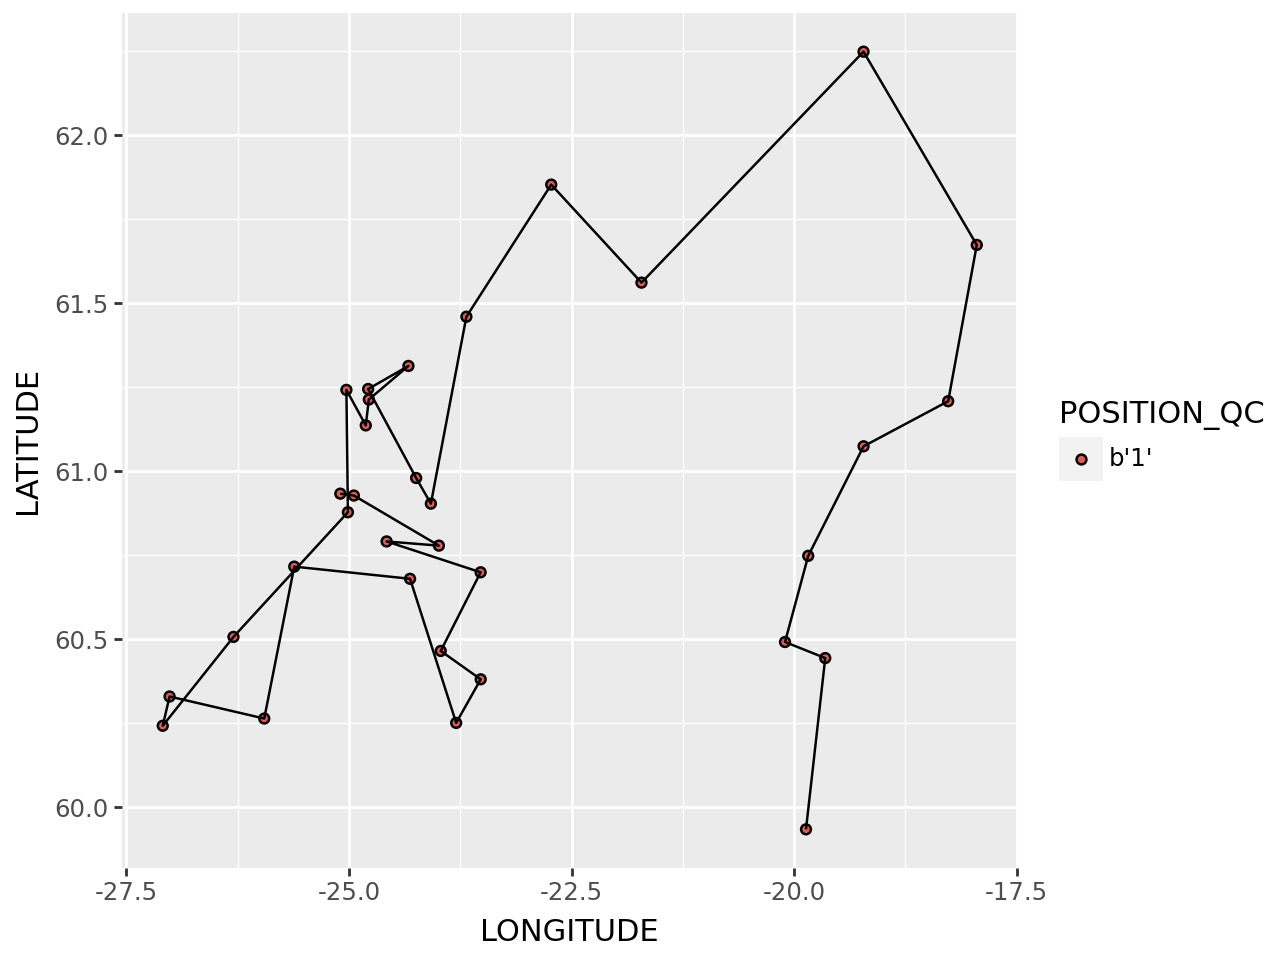

In [16]:
from plotnine import ggplot, aes, geom_point, geom_path
ggplot(lon) + geom_point(aes(x = 'LONGITUDE', y = 'LATITUDE', fill = 'POSITION_QC')) + geom_path(aes(x = 'LONGITUDE', y = 'LATITUDE'))


In [6]:
plt.figure(figsize=(12,6))
data.plot.scatter('LONGITUDE','LATITUDE',hue='POSITION_QC',s=25);
plt.grid(alpha=0.5)

KeyError: "No variable named None. Variables on the dataset include ['DATA_TYPE', 'FORMAT_VERSION', 'HANDBOOK_VERSION', 'REFERENCE_DATE_TIME', 'DATE_CREATION', ..., 'NITRATE_QC', 'NITRATE_dPRES', 'NITRATE_ADJUSTED', 'NITRATE_ADJUSTED_QC', 'NITRATE_ADJUSTED_ERROR']"

<Figure size 1200x600 with 0 Axes>

C:\Users\flapet\AppData\Local\Temp\ipykernel_12600\2394979855.py:19: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA'].values,cmap=cmap)
C:\Users\flapet\AppData\Local\Temp\ipykernel_12600\2394979855.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label=cbar_label,extend=extend)
C:\Users\flapet\AppData\Local\Temp\ipykernel_12600\2394979855.py:23: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply expli

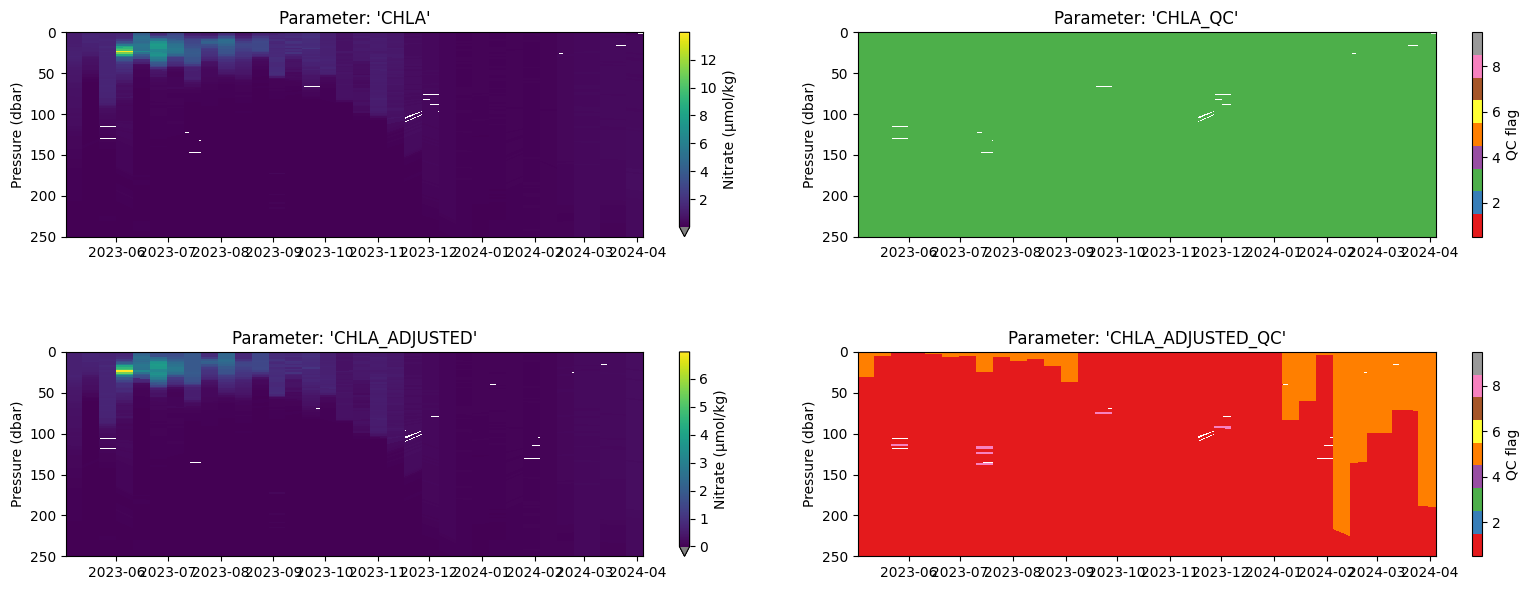

In [26]:
# Stack NumPy array of datetimes to create a 2D grid
time_2D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T

# Function for repetitive parts of plot
def config_depth_section(cbar_label,title):
  plt.ylim([0,250])
  plt.gca().invert_yaxis()
  plt.ylabel('Pressure (dbar)')
  if 'Nitrate' in cbar_label: extend = 'min'
  else:                       extend = 'neither'
  plt.colorbar(label=cbar_label,extend=extend)
  plt.title(title)

# Create subplots
plt.figure(figsize=(16,6))
plt.subplot(2,2,1)
cmap = plt.get_cmap('viridis')
cmap.set_under('0.5')
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA'].values,cmap=cmap)
config_depth_section('Nitrate (µmol/kg)',"Parameter: 'CHLA'")

plt.subplot(2,2,2)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
config_depth_section('QC flag',"Parameter: 'CHLA_QC'")

plt.subplot(2,2,3)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_ADJUSTED'].values,cmap=cmap)
config_depth_section('Nitrate (µmol/kg)',"Parameter: 'CHLA_ADJUSTED'")

plt.subplot(2,2,4)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_ADJUSTED_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
config_depth_section('QC flag',"Parameter: 'CHLA_ADJUSTED_QC'")

plt.tight_layout(h_pad=5,w_pad=3)

In [27]:
# Function to convert an array from NumPy datetime64 to Python float format
def datetime_to_float(dt):
  return (dt - np.datetime64('1900-01-01')) / np.timedelta64(1,'D')

# Function to convert an array from Python float to NumPy datetime64 format
def float_to_datetime(nums):
  return (nums * np.timedelta64(1,'D')) + np.datetime64('1900-01-01')

# Function to interpolate data from a specified float parameter to a uniform time and pressure grid
def interpolate_depth_section(param_name,specify_qc_flags=None,pres_interval=1.0):
  """
  Arguments:
      param_name: string with netCDF file parameter name (e.g., 'TEMP_ADJUSTED') to interpolate
      specify_qc_flags: None to ignore QC flags
                        or a list of QC flags (e.g., [1,2,3]) indicating which data to retain before interpolation
      pres_interval: vertical resolution for interpolating pressure (z) axis (default: 1.0 dbar)
  
  Returns:
      time_coord: 1-D NumPy array with original profile timestamps in np.datetime64 format
      pres_coord: 1-D NumPy array with a uniform pressure (z) coordinate from 0 dbar to the deepest recorded
                  pressure value, at a resolution of <pres_interval> dbar
      time_grid: 2-D NumPy array with the meshed grid of time_coord
      pres_grid: 2-D NumPy array with the meshed grid of pres_coord
      param_gridded: 2-D NumPy array with the interpolated parameter values at the locations of time_grid and pres_grid

  """

  # New grid points
  time_coord = data['JULD'].values
  pres_coord = np.arange(0,data['PRES'].max(),pres_interval)
  time_grid, pres_grid = np.meshgrid(time_coord,pres_coord)
  time_grid = datetime_to_float(time_grid)     # Convert from np.datetime64 to float

  # 1-D (flattened) versions of old grids and parameter values
  time_1D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T.flatten()
  pres_1D = data['PRES'].values.flatten()
  param_1D = data[param_name].values.flatten()
  if param_1D.dtype == object:         # If parameter is an array of QC flag data
    param_1D = param_1D.astype(float)  # Convert QC flags from dtype 'object' to float
    interp_method = 'nearest'          # Use nearest-neighbor interpolation for QC flags to avoid unwanted averaging
  else:
    interp_method = 'linear'           # Use bilinear interpolation for normal data fields

  # Extract only values matching specified QC flags
  if specify_qc_flags is not None:
    qc_1D = data[param_name + '_QC'].values.astype(float).flatten()
    qc_mask = np.tile(False,len(qc_1D))
    for qc_flag in specify_qc_flags:
      qc_mask = np.logical_or(qc_mask,qc_1D == qc_flag)
    time_1D = time_1D[qc_mask]
    pres_1D = pres_1D[qc_mask]
    param_1D = param_1D[qc_mask]

  # Remove NaN values before interpolation
  time_1D = datetime_to_float(time_1D[~np.isnan(param_1D)])       # Convert from np.datetime64 to float
  pres_1D = pres_1D[~np.isnan(param_1D)]
  param_1D = param_1D[~np.isnan(param_1D)]

  # Interpolate from irregular points to grid
  param_gridded = interpolate.griddata((time_1D,pres_1D),param_1D,(time_grid,pres_grid),method=interp_method)

  # Return coordinates, grid, and gridded data
  return time_coord, pres_coord, float_to_datetime(time_grid), pres_grid, param_gridded

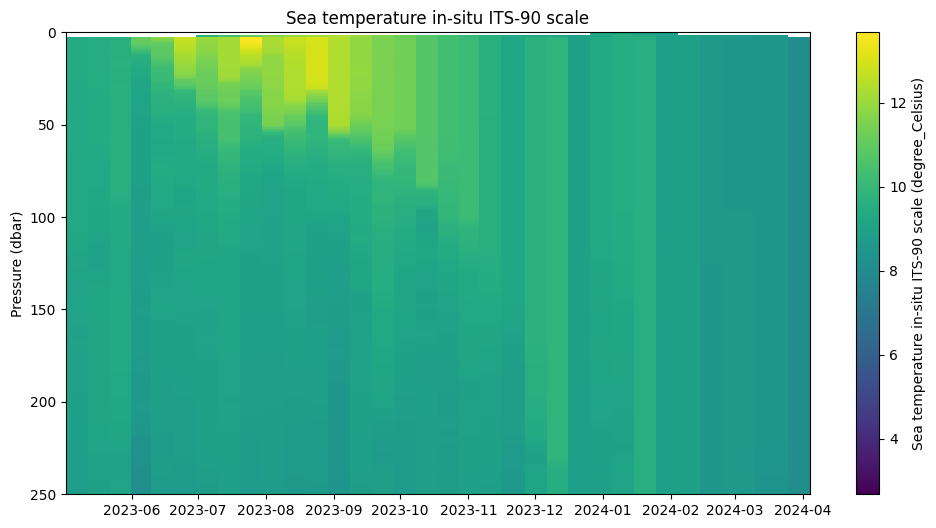

In [32]:
# Interpolate data
param_name = 'TEMP_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name);